#  Algoritma Genetika: Pengelola Jadwal Makan Sugar Glider

Tujuan dari notebook ini adalah untuk menggunakan Algoritma Genetika (GA) guna menemukan komposisi pakan mingguan yang optimal untuk sugar glider.

**Tujuan Optimasi:**
1.  Memenuhi target nutrisi (Protein, Kalsium, Fosfor).
2.  Menjaga **rasio Kalsium:Fosfor (Ca:P)** dalam rentang ideal (1:1 hingga 2:1).
3.  Mendekati total massa pakan mingguan yang direkomendasikan.
4.  Membatasi makanan tinggi gula dan makanan yang perlu "dibatasi".

**Metodologi:**
* **Individu (Kromosom):** Satu set porsi (dalam gram) untuk setiap makanan yang tersedia selama seminggu.
* **Fitness:** Skor yang dihitung berdasarkan seberapa dekat individu (menu mingguan) memenuhi semua target nutrisi. Semakin tinggi skor, semakin baik menunya.
* **Evolusi:** GA akan mengawinkan, menyilangkan (crossover), dan memutasi (mutate) individu-individu terbaik selama beberapa generasi untuk menemukan solusi yang "cukup baik" atau optimal.

In [13]:
import pandas as pd
import numpy as np
import random
import io
import matplotlib.pyplot as plt

# Mengatur agar output pandas menampilkan angka float dengan 2 desimal
pd.options.display.float_format = '{:,.2f}'.format

In [14]:
# Membaca data dari file CSV eksternal
csv_file_path = '/home/vigi/VScodeProjects/PenjadwalanMakanSugarGlider/data/data_makanan.csv'
df = pd.read_csv(csv_file_path)

# Membersihkan data: Hapus baris kategori (yang memiliki NaN di 'jenis')
df = df.dropna(subset=['jenis'])

# Mengatur tipe data
df[['protein', 'serat', 'kalsium', 'fosfor', 'gula']] = df[['protein', 'serat', 'kalsium', 'fosfor', 'gula']].astype(float)

# Mengidentifikasi makanan yang dibatasi
df['batasi'] = df['nama_makanan'].str.contains('(Batasi)', case=False, regex=False)

# Mengreset index untuk iterasi yang mudah
df = df.reset_index(drop=True)

print(f"Total makanan yang tersedia: {len(df)}")
print("Data Makanan (5 baris pertama):")
display(df.head())

# Menyimpan data ke dalam list of dictionaries agar lebih mudah diakses oleh GA
FOOD_DATA = df.to_dict('records')
GENOME_LENGTH = len(FOOD_DATA)

Total makanan yang tersedia: 30
Data Makanan (5 baris pertama):


,nama_makanan,jenis,protein,serat,kalsium,fosfor,gula,batasi
0,Jangkrik,protein,24.00,1.00,100.00,400.00,0.00,False
1,Ulat Hongkong,protein,30.00,1.60,200.00,500.00,0.00,False
2,Ayam Rebus,protein,30.00,0.00,15.00,200.00,0.00,False
3,Telur Rebus,protein,13.00,0.00,56.00,198.00,0.00,False
4,HPW Diet (Bubur),protein,20.00,3.00,250.00,200.00,8.00,False


In [15]:
# --- Parameter Algoritma Genetika ---
POPULATION_SIZE = 200
NUM_GENERATIONS = 300      # Generasi per HARI
MUTATION_RATE = 0.02
CROSSOVER_RATE = 0.8
TOURNAMENT_SIZE = 5
ELITISM_COUNT = 5

# --- Target Nutrisi Mingguan (Untuk Referensi) ---
TARGET_MASS_WEEKLY = 27.5 * 7  # (192.5g)
TARGET_PROTEIN_WEEKLY = 0.19 * TARGET_MASS_WEEKLY  # (36.58g)
TARGET_PHOSPHORUS_WEEKLY = (0.005 * TARGET_MASS_WEEKLY) * 1000 # (962.5mg)

# --- Target Nutrisi Harian (Untuk GA) ---
TARGET_MASS_DAILY = TARGET_MASS_WEEKLY / 7
TARGET_PROTEIN_DAILY = TARGET_PROTEIN_WEEKLY / 7
TARGET_PHOSPHORUS_DAILY = TARGET_PHOSPHORUS_WEEKLY / 7

# --- Target Rasio & Batasan ---
TARGET_CA_P_RATIO_MIN = 1.0
TARGET_CA_P_RATIO_MAX = 2.0
MAX_GULA_PERCENT = 0.15
MAX_BATASI_PERCENT = 0.10

print(f"--- TARGET HARIAN ---")
print(f"Target Massa Harian:      {TARGET_MASS_DAILY:.2f} g")
print(f"Target Protein Harian:    {TARGET_PROTEIN_DAILY:.2f} g")
print(f"Target Fosfor Harian:     {TARGET_PHOSPHORUS_DAILY:.2f} mg")
print(f"Target Rasio Ca:P: {TARGET_CA_P_RATIO_MIN} - {TARGET_CA_P_RATIO_MAX}")

# Mendapatkan indeks makanan suplemen untuk pembatasan
SUPPLEMENT_INDICES = df[df['jenis'] == 'supp'].index.tolist()
print(f"Index Suplemen terdeteksi (akan dibatasi): {SUPPLEMENT_INDICES}")

--- TARGET HARIAN ---
Target Massa Harian:      27.50 g
Target Protein Harian:    5.23 g
Target Fosfor Harian:     137.50 mg
Target Rasio Ca:P: 1.0 - 2.0
Index Suplemen terdeteksi (akan dibatasi): [27, 28, 29]


In [16]:
# --- 1. Fungsi Inisialisasi ---
def create_individual():
    return [random.uniform(0, 5) for _ in range(GENOME_LENGTH)]

def create_population():
    return [create_individual() for _ in range(POPULATION_SIZE)]


# --- 2. Fungsi Fitness ---

def calculate_fitness(individual, banned_indices=[], allow_supplements=True):
    """Menghitung skor fitness untuk satu individu (jadwal HARIAN)."""
    total_mass = 0
    total_protein = 0
    total_kalsium = 0
    total_fosfor = 0
    total_gula = 0
    total_batasi = 0
    total_penalty = 0 
    
    # Dictionary untuk menghitung jumlah item per jenis
    jenis_count = {} 

    for i, grams in enumerate(individual):
        
        # Penalti 0a: Penalti untuk makanan yang 'dilarang' (variasi harian)
        if i in banned_indices and grams > 0.1:
            total_penalty += (grams + 1) * 5.0 
            
        # Penalti 0b: Penalti jika menggunakan suplemen di hari terlarang
        if not allow_supplements and i in SUPPLEMENT_INDICES and grams > 0.1:
            total_penalty += (grams + 1) * 10.0 # Penalti SANGAT BESAR
            
        food = FOOD_DATA[i]

        # Logika untuk menghitung jumlah item per jenis
        if grams > 0.1: # Hanya hitung jika item "digunakan"
            jenis = food['jenis']
            if jenis != 'supp':
                jenis_count[jenis] = jenis_count.get(jenis, 0) + 1
        
        # Akumulasi nutrisi
        total_mass += grams
        total_protein += (food['protein'] / 100) * grams
        total_kalsium += (food['kalsium'] / 100) * grams
        total_fosfor += (food['fosfor'] / 100) * grams
        total_gula += (food['gula'] / 100) * grams
        
        if food['batasi']:
            total_batasi += grams

    if total_mass == 0:
        return 0

    # --- Hitung Penalti (Error) ---
    
    # Penalti 0c: Penalti untuk variasi jenis (maks 2 item per jenis)
    for jenis, count in jenis_count.items():
        if count > 2:
            penalty_amount = (count - 2) * 5.0 # Penalti 5.0 per item ekstra
            total_penalty += penalty_amount
            
    # (BARU) Penalti 0d: Penalti jika tidak seimbang (wajib ada 1 pro, 1 buah, 1 sayur)
    required_jenis = ['protein', 'buah', 'sayur']
    for rj in required_jenis:
        # Jika jenis yang dibutuhkan tidak ada di hitungan, beri penalti besar!
        if rj not in jenis_count or jenis_count[rj] == 0:
            total_penalty += 10.0 # Penalti SANGAT BESAR karena tidak seimbang
            
    
    # Penalti 1: Massa
    error_mass = ((total_mass - TARGET_MASS_DAILY) / TARGET_MASS_DAILY)**2
    total_penalty += error_mass * 1.0
    
    # Penalti 2: Protein
    error_protein = ((total_protein - TARGET_PROTEIN_DAILY) / TARGET_PROTEIN_DAILY)**2
    total_penalty += error_protein * 1.5
    
    # Penalti 3: Fosfor
    error_fosfor = ((total_fosfor - TARGET_PHOSPHORUS_DAILY) / TARGET_PHOSPHORUS_DAILY)**2
    total_penalty += error_fosfor * 1.0
    
    # Penalti 4: Rasio Ca:P
    if total_fosfor > 0:
        ca_p_ratio = total_kalsium / total_fosfor
        if ca_p_ratio < TARGET_CA_P_RATIO_MIN:
            total_penalty += (TARGET_CA_P_RATIO_MIN - ca_p_ratio) * 5.0
        elif ca_p_ratio > TARGET_CA_P_RATIO_MAX:
            total_penalty += (ca_p_ratio - TARGET_CA_P_RATIO_MAX) * 5.0
    else:
        total_penalty += 10
    
    # Penalti 5: Gula
    gula_percent = total_gula / total_mass
    if gula_percent > MAX_GULA_PERCENT:
        total_penalty += (gula_percent - MAX_GULA_PERCENT) * 2.0
        
    # Penalti 6: Makanan 'Batasi'
    batasi_percent = total_batasi / total_mass
    if batasi_percent > MAX_BATASI_PERCENT:
        total_penalty += (batasi_percent - MAX_BATASI_PERCENT) * 3.0

    fitness_score = 1.0 / (1.0 + total_penalty)
    
    return fitness_score


# --- 3. Fungsi Seleksi (Tournament) ---
# (Tetap sama seperti sebelumnya)
def select_parent(population_with_fitness):
    tournament = random.sample(population_with_fitness, TOURNAMENT_SIZE)
    tournament.sort(key=lambda x: x[1], reverse=True)
    return tournament[0][0]


# --- 4. Fungsi Crossover (Single-Point) ---
# (Tetap sama seperti sebelumnya)
def crossover(parent1, parent2):
    if random.random() > CROSSOVER_RATE:
        return parent1.copy(), parent2.copy()
    point = random.randint(1, GENOME_LENGTH - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2


# --- 5. Fungsi Mutasi ---
# (Tetap sama seperti sebelumnya)
def mutate(individual):
    mutated_individual = individual.copy()
    for i in range(GENOME_LENGTH):
        if random.random() < MUTATION_RATE:
            mutation_amount = random.uniform(-2.5, 2.5)
            mutated_individual[i] += mutation_amount
            if mutated_individual[i] < 0:
                mutated_individual[i] = 0
    return mutated_individual

In [17]:

weekly_schedule = []  
all_used_main_food_indices = [] 
all_best_fitness_histories = [] 
# (BARU) List untuk menyimpan semua riwayat rata-rata
all_average_fitness_histories = [] 


# --- Helper function untuk menemukan makanan utama ---
def get_main_food_indices(individual, top_n=2):
    """Mendapatkan index dari N makanan teratas (protein/buah/sayur)."""
    food_with_grams = []
    for i, grams in enumerate(individual):
        if grams > 1.0: # Hanya pertimbangkan jika lebih dari 1 gram
            jenis = FOOD_DATA[i]['jenis']
            if jenis in ['protein', 'buah', 'sayur']:
                food_with_grams.append((i, grams))
    food_with_grams.sort(key=lambda x: x[1], reverse=True)
    indices = [item[0] for item in food_with_grams[:top_n]]
    return indices

# --- Pilih 3 hari acak untuk suplemen ---
days_with_supplements = sorted(random.sample(range(7), 3))
print(f"Suplemen HANYA akan diizinkan pada hari: {[d+1 for d in days_with_supplements]}")


# --- Loop Master 7-Hari ---
for day in range(7):
    current_day_allowed_supps = (day in days_with_supplements)
    
    print("\n" + "="*70)
    print(f" Menghasilkan Menu untuk HARI KE-{day + 1}")
    print(f"   Suplemen Diizinkan: {current_day_allowed_supps}")
    print(f"   Index makanan yang dilarang (variasi): {all_used_main_food_indices}")
    print("="*70)
    
    # 1. Buat populasi baru untuk hari ini
    population = create_population()
    best_fitness_history = []
    average_fitness_history = []# Inisialisasi riwayat rata-rata

    # 2. Loop Generasi (GA standar)
    for gen in range(NUM_GENERATIONS):
        
        pop_with_fitness = [(ind, calculate_fitness(
            ind, 
            banned_indices=all_used_main_food_indices, 
            allow_supplements=current_day_allowed_supps
        )) for ind in population]
        
        pop_with_fitness.sort(key=lambda x: x[1], reverse=True)
        
        # Catat fitness
        best_fitness = pop_with_fitness[0][1]
        avg_fitness = sum(f[1] for f in pop_with_fitness) / POPULATION_SIZE
        best_fitness_history.append(best_fitness)
        average_fitness_history.append(avg_fitness) # <-- SIMPAN RATA-RATA
        
        # Cetak fitness terbaik dan rata-rata setiap 10 generasi
        if gen % 10 == 0 or gen == NUM_GENERATIONS - 1:
            print(f"  Gen {gen:03d} | Fitness Terbaik: {best_fitness:.4f} | Rata-rata: {avg_fitness:.4f}")
            
        # 3. Buat populasi baru (Seleksi, Crossover, Mutasi)
        new_population = []
        
        for i in range(ELITISM_COUNT):
            new_population.append(pop_with_fitness[i][0])
            
        while len(new_population) < POPULATION_SIZE:
            parent1 = select_parent(pop_with_fitness)
            parent2 = select_parent(pop_with_fitness)
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutate(child1))
            if len(new_population) < POPULATION_SIZE:
                new_population.append(mutate(child2))
                
        population = new_population

    # 4. Selesai GA untuk hari ini, dapatkan pemenangnya
    pop_with_fitness = [(ind, calculate_fitness(
        ind, 
        banned_indices=all_used_main_food_indices, 
        allow_supplements=current_day_allowed_supps
    )) for ind in population]
    pop_with_fitness.sort(key=lambda x: x[1], reverse=True)
    best_individual_today = pop_with_fitness[0][0]
    
    # 5. Simpan hasil
    weekly_schedule.append(best_individual_today)
    all_best_fitness_histories.append(best_fitness_history)
    all_average_fitness_histories.append(average_fitness_history) # <-- SIMPAN RIWAYAT RATA-RATA
    
    # 6. Update "memori"
    main_foods_today = get_main_food_indices(best_individual_today, top_n=2)
    new_banned_indices = []
    for idx in main_foods_today:
        if idx not in all_used_main_food_indices:
            new_banned_indices.append(idx)
            
    all_used_main_food_indices.extend(new_banned_indices)
    print(f"  -> Menu Hari {day+1} ditemukan. Makanan utama baru yang diblokir: {new_banned_indices}")


Suplemen HANYA akan diizinkan pada hari: [1, 3, 5]

 Menghasilkan Menu untuk HARI KE-1
   Suplemen Diizinkan: True
   Index makanan yang dilarang (variasi): []
  Gen 000 | Fitness Terbaik: 0.0105 | Rata-rata: 0.0087
  Gen 010 | Fitness Terbaik: 0.0316 | Rata-rata: 0.0191
  Gen 020 | Fitness Terbaik: 0.1569 | Rata-rata: 0.0829
  Gen 030 | Fitness Terbaik: 0.8562 | Rata-rata: 0.6441
  Gen 040 | Fitness Terbaik: 0.9276 | Rata-rata: 0.8428
  Gen 050 | Fitness Terbaik: 0.9365 | Rata-rata: 0.8699
  Gen 060 | Fitness Terbaik: 0.9404 | Rata-rata: 0.8722
  Gen 070 | Fitness Terbaik: 0.9443 | Rata-rata: 0.8324
  Gen 080 | Fitness Terbaik: 0.9454 | Rata-rata: 0.8878
  Gen 090 | Fitness Terbaik: 0.9488 | Rata-rata: 0.8913
  Gen 100 | Fitness Terbaik: 0.9502 | Rata-rata: 0.8770
  Gen 110 | Fitness Terbaik: 0.9513 | Rata-rata: 0.8736
  Gen 120 | Fitness Terbaik: 0.9536 | Rata-rata: 0.9080
  Gen 130 | Fitness Terbaik: 0.9589 | Rata-rata: 0.9257
  Gen 140 | Fitness Terbaik: 0.9589 | Rata-rata: 0.9341


 Memvisualisasikan Riwayat Fitness Harian:
Plot menampilkan garis Best Fitness dan Average Fitness per Generasi.


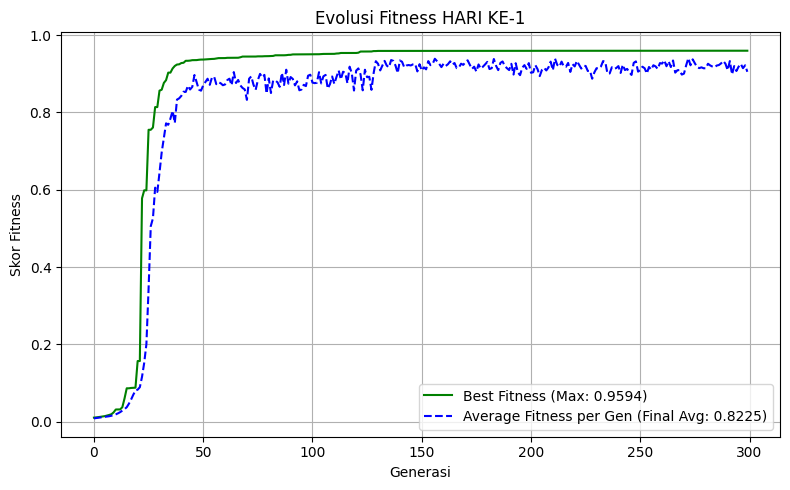

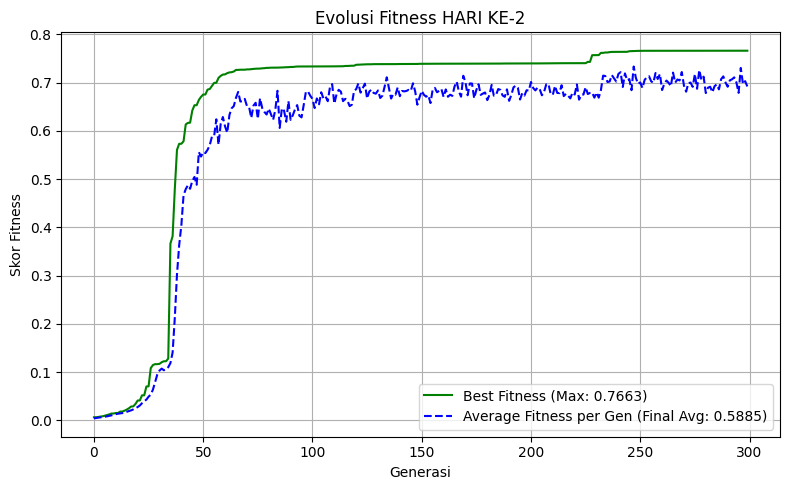

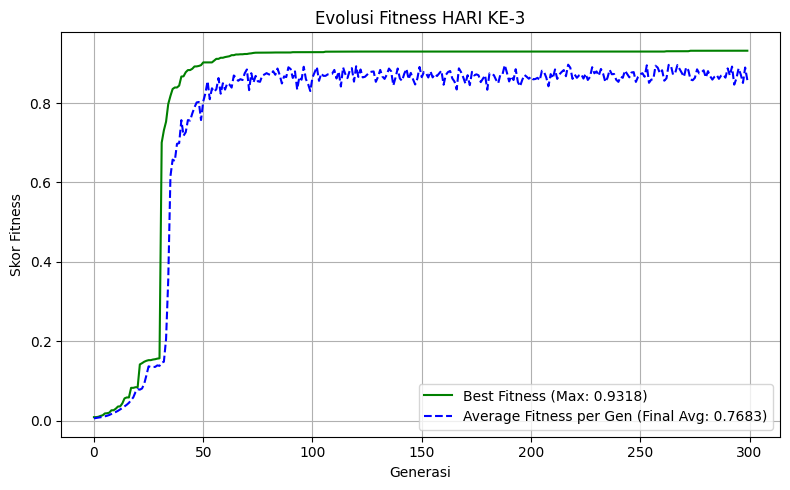

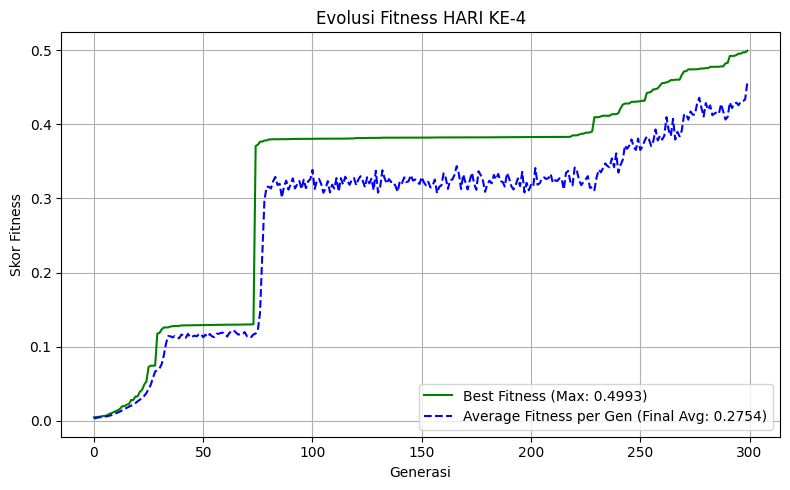

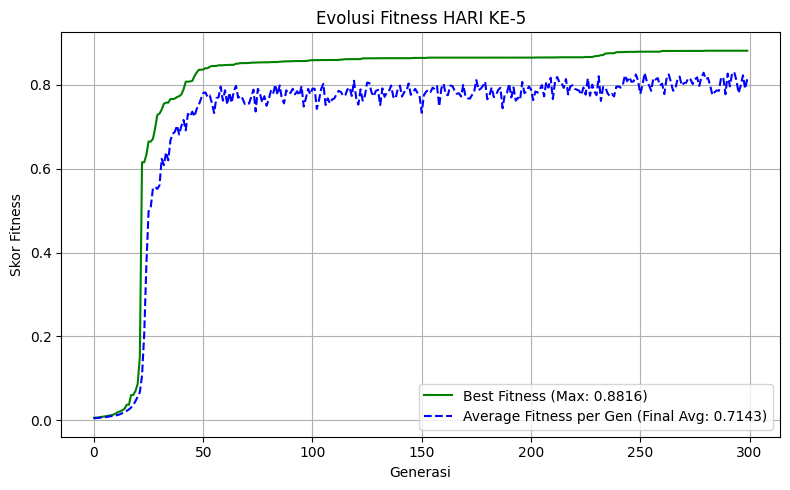

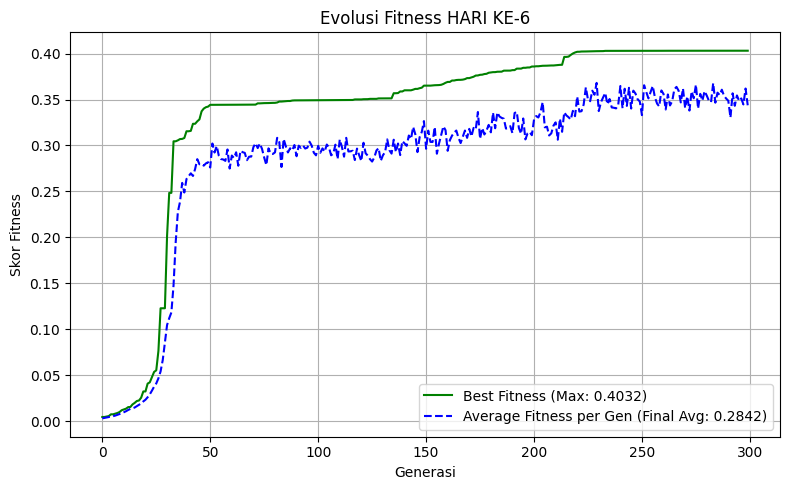

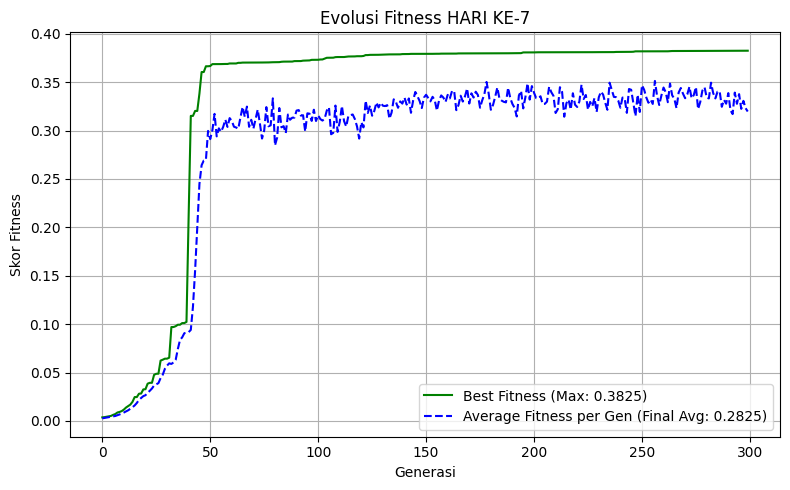


Visualisasi Fitness 7-Hari Selesai.


In [18]:
print(" Memvisualisasikan Riwayat Fitness Harian:")
print("Plot menampilkan garis Best Fitness dan Average Fitness per Generasi.")

# Loop melalui 7 riwayat fitness (satu untuk setiap hari)
# Kita loop dengan index i agar bisa mengakses both all_best_fitness_histories dan all_average_fitness_histories
for i in range(7):
    best_history = all_best_fitness_histories[i]
    average_history = all_average_fitness_histories[i]
    
    # Hitung nilai tertinggi dan rata-rata akhir untuk label legend
    best_fitness_max = max(best_history)
    best_fitness_avg_final = sum(average_history) / len(average_history)

    plt.figure(figsize=(8, 5))
    
    # Plot 1: Best Fitness
    plt.plot(best_history, 
             label=f"Best Fitness (Max: {best_fitness_max:.4f})", 
             color='green')
    
    # (BARU) Plot 2: Average Fitness per Generasi
    plt.plot(average_history, 
             label=f"Average Fitness per Gen (Final Avg: {best_fitness_avg_final:.4f})", 
             color='blue', 
             linestyle='--')
    
    # Judul dan label
    plt.title(f"Evolusi Fitness HARI KE-{i+1}")
    plt.xlabel("Generasi")
    plt.ylabel("Skor Fitness")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
print("\nVisualisasi Fitness 7-Hari Selesai.")

In [19]:
def analyze_daily_solution(individual, day_num):
    """Fungsi helper untuk menganalisis dan mencetak solusi HARIAN."""
    
    schedule_df = df.copy()
    schedule_df['gram_harian'] = individual
    
    # Hitung nutrisi
    schedule_df['protein_g'] = (schedule_df['protein'] / 100) * schedule_df['gram_harian']
    schedule_df['kalsium_mg'] = (schedule_df['kalsium'] / 100) * schedule_df['gram_harian']
    schedule_df['fosfor_mg'] = (schedule_df['fosfor'] / 100) * schedule_df['gram_harian']
    schedule_df['gula_g'] = (schedule_df['gula'] / 100) * schedule_df['gram_harian']
    schedule_df['batasi_g'] = schedule_df.apply(lambda row: row['gram_harian'] if row['batasi'] else 0, axis=1)
    
    # Filter hanya makanan yang digunakan (lebih dari 0.1g)
    used_food_df = schedule_df[schedule_df['gram_harian'] > 0.1].sort_values(by='gram_harian', ascending=False)
    
    # Hitung Total Harian
    total_mass = used_food_df['gram_harian'].sum()
    total_protein = used_food_df['protein_g'].sum()
    total_kalsium = used_food_df['kalsium_mg'].sum()
    total_fosfor = used_food_df['fosfor_mg'].sum()
    total_gula = used_food_df['gula_g'].sum()
    total_batasi = used_food_df['batasi_g'].sum()
    
    ca_p_ratio = total_kalsium / total_fosfor if total_fosfor > 0 else 0
    gula_percent = (total_gula / total_mass) * 100 if total_mass > 0 else 0
    
    print("\n" + "="*30)
    print(f"       MENU HARI KE-{day_num}")
    print("="*30)
    
    print(" Daftar Pakan (Gram Harian):")
    display(used_food_df[['nama_makanan', 'jenis', 'gram_harian', 'protein_g', 'kalsium_mg', 'fosfor_mg']])
    
    print("\n Analisis Nutrisi Harian:")
    print(f"  Rasio Ca:P:    {ca_p_ratio:.2f} : 1  (Target: {TARGET_CA_P_RATIO_MIN:.1f} - {TARGET_CA_P_RATIO_MAX:.1f})")
    print(f"  Total Massa:     {total_mass:.2f} g    (Target: {TARGET_MASS_DAILY:.2f} g)")
    print(f"  Total Protein:   {total_protein:.2f} g    (Target: {TARGET_PROTEIN_DAILY:.2f} g)")
    print(f"  Total Kalsium: {total_kalsium:.2f} mg")
    print(f"  Total Fosfor:  {total_fosfor:.2f} mg    (Target: {TARGET_PHOSPHORUS_DAILY:.2f} mg)")
    print(f"  Total Gula:      {total_gula:.2f} g     ({gula_percent:.1f}% dari massa)")

    # Kembalikan total untuk rekap mingguan
    return total_mass, total_protein, total_kalsium, total_fosfor, total_gula

# --- Jalankan Analisis untuk 7 Hari ---
print("======================================================")
print("      HASIL OPTIMASI JADWAL MAKAN 7-HARI")
print("======================================================")

total_weekly_mass = 0
total_weekly_protein = 0
total_weekly_kalsium = 0
total_weekly_fosfor = 0

for i, daily_menu in enumerate(weekly_schedule):
    m, p, k, f, g = analyze_daily_solution(daily_menu, day_num=i+1)
    total_weekly_mass += m
    total_weekly_protein += p
    total_weekly_kalsium += k
    total_weekly_fosfor += f

# --- Tampilkan Total Mingguan (Hasil Penjumlahan 7 Hari) ---
print("\n\n" + "="*40)
print("       REKAPITULASI TOTAL MINGGUAN")
print(" (Hasil penjumlahan 7 menu harian di atas)")
print("="*40)

final_ca_p_ratio = total_weekly_kalsium / total_weekly_fosfor if total_weekly_fosfor > 0 else 0

print(f"Rasio Ca:P (Total):    {final_ca_p_ratio:.2f} : 1  (Target: {TARGET_CA_P_RATIO_MIN:.1f} - {TARGET_CA_P_RATIO_MAX:.1f})")
print(f"Total Massa (Total):     {total_weekly_mass:.2f} g    (Target: {TARGET_MASS_WEEKLY:.2f} g)")
print(f"Total Protein (Total):   {total_weekly_protein:.2f} g    (Target: {TARGET_PROTEIN_WEEKLY:.2f} g)")
print(f"Total Kalsium (Total): {total_weekly_kalsium:.2f} mg")
print(f"Total Fosfor (Total):  {total_weekly_fosfor:.2f} mg    (Target: {TARGET_PHOSPHORUS_WEEKLY:.2f} mg)")

      HASIL OPTIMASI JADWAL MAKAN 7-HARI

       MENU HARI KE-1
 Daftar Pakan (Gram Harian):


,nama_makanan,jenis,gram_harian,protein_g,kalsium_mg,fosfor_mg
29,Bee Pollen,supp,14.00,2.52,14.00,56.01
1,Ulat Hongkong,protein,9.17,2.75,18.33,45.83
28,Multivitamin Bubuk,supp,5.02,0.25,25.12,10.05
27,Kalsium Bubuk,supp,0.55,0.00,54.50,0.00
10,Pir,buah,0.11,0.00,0.01,0.01
22,Timun,sayur,0.11,0.00,0.02,0.03



 Analisis Nutrisi Harian:
  Rasio Ca:P:    1.00 : 1  (Target: 1.0 - 2.0)
  Total Massa:     28.96 g    (Target: 27.50 g)
  Total Protein:   5.52 g    (Target: 5.23 g)
  Total Kalsium: 111.98 mg
  Total Fosfor:  111.93 mg    (Target: 137.50 mg)
  Total Gula:      4.31 g     (14.9% dari massa)

       MENU HARI KE-2
 Daftar Pakan (Gram Harian):


,nama_makanan,jenis,gram_harian,protein_g,kalsium_mg,fosfor_mg
4,HPW Diet (Bubur),protein,23.93,4.79,59.83,47.86
0,Jangkrik,protein,2.96,0.71,2.96,11.83
19,Jagung,sayur,2.29,0.07,0.05,2.47
9,Melon,buah,0.13,0.00,0.01,0.02



 Analisis Nutrisi Harian:
  Rasio Ca:P:    1.01 : 1  (Target: 1.0 - 2.0)
  Total Massa:     29.30 g    (Target: 27.50 g)
  Total Protein:   5.57 g    (Target: 5.23 g)
  Total Kalsium: 62.84 mg
  Total Fosfor:  62.18 mg    (Target: 137.50 mg)
  Total Gula:      2.06 g     (7.0% dari massa)

       MENU HARI KE-3
 Daftar Pakan (Gram Harian):


,nama_makanan,jenis,gram_harian,protein_g,kalsium_mg,fosfor_mg
5,Belalang,protein,13.86,3.05,16.63,48.51
29,Bee Pollen,supp,11.69,2.10,11.69,46.75
28,Multivitamin Bubuk,supp,4.14,0.21,20.68,8.27
27,Kalsium Bubuk,supp,0.55,0.00,54.85,0.00
26,Tomat (Batasi),sayur,0.11,0.00,0.01,0.03
7,Apel,buah,0.10,0.00,0.01,0.01



 Analisis Nutrisi Harian:
  Rasio Ca:P:    1.00 : 1  (Target: 1.0 - 2.0)
  Total Massa:     30.44 g    (Target: 27.50 g)
  Total Protein:   5.36 g    (Target: 5.23 g)
  Total Kalsium: 103.87 mg
  Total Fosfor:  103.57 mg    (Target: 137.50 mg)
  Total Gula:      3.60 g     (11.8% dari massa)

       MENU HARI KE-4
 Daftar Pakan (Gram Harian):


,nama_makanan,jenis,gram_harian,protein_g,kalsium_mg,fosfor_mg
21,Bayam,sayur,18.30,0.53,18.11,8.97
18,Buncis,sayur,7.95,0.14,2.94,3.34
2,Ayam Rebus,protein,4.14,1.24,0.62,8.27
6,Ikan Salmon (Matang),protein,3.94,0.99,0.35,7.89
16,Kiwi,buah,0.16,0.00,0.06,0.06



 Analisis Nutrisi Harian:
  Rasio Ca:P:    0.77 : 1  (Target: 1.0 - 2.0)
  Total Massa:     34.49 g    (Target: 27.50 g)
  Total Protein:   2.90 g    (Target: 5.23 g)
  Total Kalsium: 22.09 mg
  Total Fosfor:  28.52 mg    (Target: 137.50 mg)
  Total Gula:      0.33 g     (0.9% dari massa)

       MENU HARI KE-5
 Daftar Pakan (Gram Harian):


,nama_makanan,jenis,gram_harian,protein_g,kalsium_mg,fosfor_mg
29,Bee Pollen,supp,14.41,2.59,14.41,57.64
6,Ikan Salmon (Matang),protein,8.86,2.22,0.80,17.73
28,Multivitamin Bubuk,supp,7.18,0.36,35.91,14.36
27,Kalsium Bubuk,supp,0.40,0.00,39.50,0.00
17,Wortel,sayur,0.11,0.00,0.04,0.04
12,Pisang,buah,0.10,0.00,0.01,0.02



 Analisis Nutrisi Harian:
  Rasio Ca:P:    1.01 : 1  (Target: 1.0 - 2.0)
  Total Massa:     31.06 g    (Target: 27.50 g)
  Total Protein:   5.17 g    (Target: 5.23 g)
  Total Kalsium: 90.66 mg
  Total Fosfor:  89.79 mg    (Target: 137.50 mg)
  Total Gula:      4.48 g     (14.4% dari massa)

       MENU HARI KE-6
 Daftar Pakan (Gram Harian):


,nama_makanan,jenis,gram_harian,protein_g,kalsium_mg,fosfor_mg
23,Brokoli,sayur,19.43,0.54,9.13,12.82
24,Kubis,sayur,7.82,0.10,3.13,2.03
2,Ayam Rebus,protein,2.71,0.81,0.41,5.43
14,Jeruk (Batasi),buah,0.98,0.01,0.39,0.14



 Analisis Nutrisi Harian:
  Rasio Ca:P:    0.64 : 1  (Target: 1.0 - 2.0)
  Total Massa:     30.94 g    (Target: 27.50 g)
  Total Protein:   1.47 g    (Target: 5.23 g)
  Total Kalsium: 13.06 mg
  Total Fosfor:  20.42 mg    (Target: 137.50 mg)
  Total Gula:      0.67 g     (2.2% dari massa)

       MENU HARI KE-7
 Daftar Pakan (Gram Harian):


,nama_makanan,jenis,gram_harian,protein_g,kalsium_mg,fosfor_mg
16,Kiwi,buah,11.86,0.13,4.03,4.03
17,Wortel,sayur,7.69,0.07,2.54,2.69
25,Ubi Jalar (Matang),sayur,7.27,0.12,2.18,3.42
2,Ayam Rebus,protein,2.94,0.88,0.44,5.89
3,Telur Rebus,protein,0.27,0.04,0.15,0.54



 Analisis Nutrisi Harian:
  Rasio Ca:P:    0.56 : 1  (Target: 1.0 - 2.0)
  Total Massa:     30.03 g    (Target: 27.50 g)
  Total Protein:   1.23 g    (Target: 5.23 g)
  Total Kalsium: 9.34 mg
  Total Fosfor:  16.56 mg    (Target: 137.50 mg)
  Total Gula:      1.76 g     (5.9% dari massa)


       REKAPITULASI TOTAL MINGGUAN
 (Hasil penjumlahan 7 menu harian di atas)
Rasio Ca:P (Total):    0.96 : 1  (Target: 1.0 - 2.0)
Total Massa (Total):     215.22 g    (Target: 192.50 g)
Total Protein (Total):   27.23 g    (Target: 36.58 g)
Total Kalsium (Total): 413.83 mg
Total Fosfor (Total):  432.97 mg    (Target: 962.50 mg)
